### Описание данных  

Файл содержит [биржевой стакан](https://en.wikipedia.org/wiki/Order_book_(trading)) для некоторого актива. Стакан состоит из ценовых уровней и объема заявок на каждом уровне. Глубина стакана - 5.  

Описание колонок:  
ask_rate - цены заявок на продажу  
ask_amount - объёмы заявок на продажу  
bid_rate - цены заявок на покупку  
bid_amount - объёмы заявок на покупку
midprice - цена актива  
signal - сигнал, полученный от модели, которая оценивает изменение цены 

#### Цена актива
На каждый тик определим цену актива. Возьмём среднее между наименьшим ask_rate (askbest) и наибольшим bid_rate (bidbest) в момент времени t:  
$$ midprice(t) = \frac{(askbest(t) + bidbest(t))}{2} $$  

С помощью сигнала от модели определим прогноз цены в будущем:  
$$midprice(t + 1) = midprice(t) + signal(t)$$

### Считывание данных

In [1]:
# !pip3 install fastparquet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtest import *

In [3]:
backtest_df = pd.read_parquet('test_quant.parquet')

In [4]:
backtest_df.tail()

,ask_rate,ask_amount,bid_rate,bid_amount,midprice,target,signal
index,,,,,,,
2019-09-18 06:08:46.227,"[380.02, 380.03, 380.04, 380.05, 380.07]","[4.57266, 54.3976, 0.50151, 0.48145, 0.50151]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 7.23986, 0.031, 1.45021, 10.41323]",380.015,-0.010,-0.000562
2019-09-18 06:08:46.427,"[380.02, 380.03, 380.04, 380.05, 380.06]","[9.0, 58.97026, 0.50151, 0.48145, 0.13]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 7.23986, 0.24296, 0.02895, 10.41323]",380.015,-0.010,-0.002318
2019-09-18 06:08:46.527,"[380.02, 380.03, 380.04, 380.05, 380.06]","[13.57266, 54.3976, 0.50151, 0.48145, 0.13]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 0.66331, 0.24296, 0.02895, 10.41323]",380.015,-0.010,-0.001896
2019-09-18 06:08:46.627,"[380.02, 380.03, 380.04, 380.05, 380.06]","[13.57266, 54.3976, 0.50151, 0.72768, 0.13]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 0.66331, 0.031, 0.02895, 2.41323]",380.015,-0.010,-0.002480
2019-09-18 06:08:46.827,"[380.01, 380.02, 380.03, 380.05, 380.06]","[66.5, 4.57266, 54.3976, 0.24623, 0.13]","[380.0, 379.99, 379.98, 379.96, 379.94]","[0.66331, 0.031, 0.02895, 2.41323, 5.73953]",380.005,-0.055,-0.005292


In [5]:
backtest_df.shape

(787690, 7)

### Пример стратегии

#### Принцип работы стратегии  
Стратегия - это некоторый набор условий, по которому в каждый момент времени принимается решение, нужно ли сейчас покупать, продавать, либо ничего не делать.  
Результат работы стратегии - необходимый объем сделки (```order_size```). Если значение объема положительное - совершается покупка (buy). Если отрицательное - продажа (sell). Если 0 - ничего не происходит (hold).  

```order_size = 1``` — сделать покупку объемом 1  
```order_size = -1``` — сделать продажу объемом 1  

Совершение сделки на покупку изменяет текущую позицию (```current_position```) в положительную сторону, на продажу - в отрицательную.  
Текущая позиция отражает кумулятивную сумму купленных и проданных объемов.  
Пример изменения текущей позиции:  

```1. order_size = 0 -> current_position = 0```  
```2. order_size = 1 -> current_position = 1  # открытие позиции```  
```3. order_size = -1 -> current_position = 0  # закрытие позиции```  
  
Максимальная позиция (```max_position```) - наибольшее абсолютное значение текущей позиции. Если текущая позиция равна максимальной, нельзя совершать сделки в ту же сторону.  
При ```max_position = 1```:   

```1. order_size = 0 -> current_position = 0```  
```2. order_size = -1 -> current_position = -1```  
```3. order_size = -1 -> current_position = -1  # нельзя превысить max_position```   
```4. order_size = 1 -> current_position = 0```   

In [6]:
def basic_strategy(strategy_state, orderbook_state, trade_size, storage, max_position=1):
    '''
    Описание стратегии
    --------------
    Совершает покупку, если сигнал положительный и текущая абсолютная позиция меньше максимальной.
    Совершает продажу, если сигнал отрицательный и текущая абсолютная позиция меньше максимальной.
    
    Параметры
    --------------
    strategy_state : list
        Массив, содержащий index (номер тика), current_position (текущую позицию)
        и signal (сигнал модели для данного тика).
    orderbook_state : list
        Массив, содержащий информацию о стакане для данного тика.
    trade_size : float
        Объем одной сделки.
    storage : dict
        Словарь для сохранения информации с прошлых тиков.
    max_position : int
        Максимальный объем открытой позиции в одну сторону. Должен быть равен 1.
    
    Результат
    --------------
    order_size : float
        Стратегия возвращает объем сделки, где знак обозначает сторону сделки: 
        положительный для покупки и отрицательный для продажи
    '''
    index, current_position, signal = strategy_state
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state
    
    # prev_signal = storage.get('prev_signal', 0)  # пример использования storage
    if signal > 0:  # покупка
        order_size = min(trade_size, max_position - current_position)  # определение объема сделки
    elif signal < 0:  # продажа
        order_size = -min(trade_size, max_position + current_position)  # определение объема сделки
    else:
        order_size = 0
    # storage['prev_signal'] = signal  # пример использования storage
    
    return order_size

In [7]:
strategy_params = {}
strategy_params['trade_size'] = 1  # максимальное значение = 1
strategy_params['storage'] = {}  

### Бэктест
Для проверки качества стратегии используются исторические данные, на которых с помощью бэктеста симулируется работа стратегии

{'pnl': -2274.46404689842, 'pnl_after_fee': -13516.510304403007, 'actions': 326340}


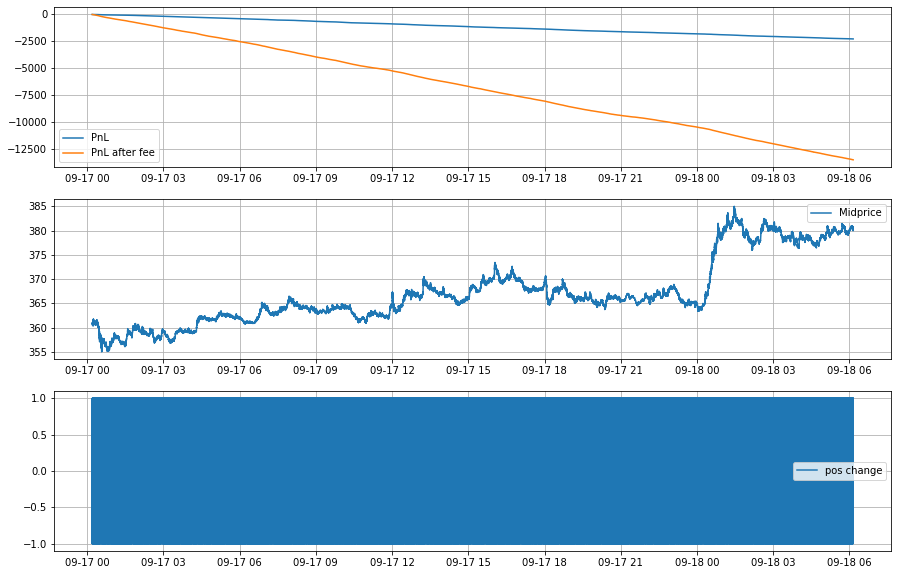

In [8]:
summary, result = backtest(backtest_df, basic_strategy, strategy_params, viz=True)

Бэктест возвращает результат работы стратегии.  
```summary``` содержит итоговую информацию:
- pnl : Profits and Losses (PnL, P&L) - сумма всех доходов и убытков по закрытым позициям. 
- **pnl_after_fee : Pnl после комиссии. За каждую сделку биржа берёт комиссию. В данном случае она составляет 0.0001 от цены актива в момент совершения сделки. Это ключевой показатель при анализе эффективности стратегии.**  
- actions : Количество сделок, совершенное стратегией  

Выводы по этой стратегии:  
Она слишком чувствительна к сигналу, поэтому совершает большое количество сделок, из которых почти все убыточны. 

```result``` - исходный датафрейм, к которому добавлены данные по стратегии в каждый момент времени. Может использоваться для детального анализа работы стратегии

Ниже пример работы другой стратегии. Его можно использовать как бейзлайн.

{'pnl': 40.425888500000305, 'pnl_after_fee': 27.54488769229031, 'actions': 374}


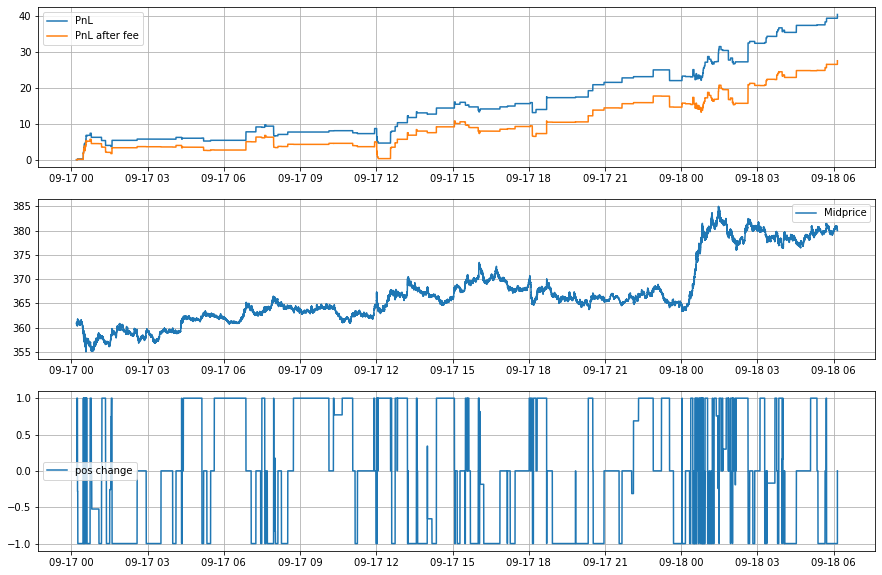

In [12]:
# summary, result = backtest(backtest_df, strategy, strategy_params, viz=True)

### Задачa
Написать свою торговую стратегию, которая будет опираться на сигнал модели для принятия решения.  
#### Ограничения: 
- Максимальная позиция не должна превышать 1
- Нельзя самостоятельно вносить изменения в бэктест
- Стратегия должна содержать текстовое описание  

#### Критерии оценки стратегии:
- Pnl после комиссии 
- Количество сделок > 50